# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

import torch.nn as nn
import torch.nn.functional as F

import torch
from torchvision import datasets
from torchvision import transforms
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    image_transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                          transforms.ToTensor()])
    data = datasets.ImageFolder(root=data_dir, transform=image_transform)
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, pin_memory=True)
    return loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

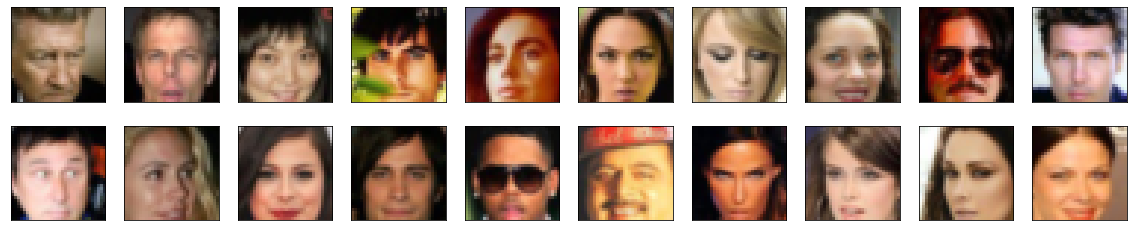

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''  
    return (x * 2) - 1


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.7804)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
class ConvNormBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, kernel: int, 
                 stride: int, padding: int, lrelu_slope: float=0.2) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=kernel, stride=stride, padding=padding, bias=False)
        self.norm = nn.BatchNorm2d(out_dim)
        self.activation = nn.LeakyReLU(lrelu_slope)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x

In [9]:
import cnn_shape


def analyze_discriminator_data_shapes(input_shape: torch.Size) -> None:
    test_layers = nn.ModuleList([nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
                                 nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                                 nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                                 nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
                                 nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0)])
    
    data_shapes = cnn_shape.get_layer_output_shapes(input_shape, test_layers)
    print(*data_shapes.values(), sep = "\n")
    
analyze_discriminator_data_shapes(input_shape = (100, 3, 32, 32))    

torch.Size([100, 64, 16, 16])
torch.Size([100, 128, 8, 8])
torch.Size([100, 256, 4, 4])
torch.Size([100, 512, 2, 2])
torch.Size([100, 1, 1, 1])


In [10]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim: int) -> None:
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            ConvNormBlock(conv_dim, conv_dim*2, kernel=4, stride=2, padding=1),
            ConvNormBlock(conv_dim*2, conv_dim*4, kernel=4, stride=2, padding=1),
            ConvNormBlock(conv_dim*4, conv_dim*8, kernel=4, stride=2, padding=1),
            nn.Conv2d( conv_dim*8, 1, kernel_size=2, stride=1, padding=0))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        return torch.flatten(self.layers(x), start_dim=1)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class TConvNormBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, kernel: int, stride: int, padding: int) -> None:
        super().__init__()
        self.tconv = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=kernel, stride=stride, padding=padding, bias=False)
        self.norm = nn.BatchNorm2d(out_dim)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.tconv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x

In [12]:
def analyze_generator_data_shapes(input_shape: torch.Size) -> None:
    test_layers = nn.ModuleList([nn.ConvTranspose2d(100, 512, kernel_size=4, stride=2, padding=1),
                                 nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
                                 nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                                 nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                                 nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)])
    
    data_shapes = cnn_shape.get_layer_output_shapes(input_shape, test_layers)
    print(*data_shapes.values(), sep = "\n")
    
analyze_generator_data_shapes(input_shape = (100, 100, 1, 1)) 

torch.Size([100, 512, 2, 2])
torch.Size([100, 256, 4, 4])
torch.Size([100, 128, 8, 8])
torch.Size([100, 64, 16, 16])
torch.Size([100, 3, 32, 32])


In [13]:
class Generator(nn.Module):
    def __init__(self, z_size: int, conv_dim: int) -> None:
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super().__init__()
        self.layers = nn.Sequential(
            TConvNormBlock(z_size, conv_dim*8, kernel=4, stride=2, padding=1),
            TConvNormBlock(conv_dim*8, conv_dim*4, kernel=4, stride=2, padding=1),
            TConvNormBlock(conv_dim*4, conv_dim*2, kernel=4, stride=2, padding=1),
            TConvNormBlock(conv_dim*2, conv_dim, kernel=4, stride=2, padding=1),
            nn.ConvTranspose2d(conv_dim, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = torch.unsqueeze(x, dim=2)
        x = torch.unsqueeze(x, dim=3)
        return self.layers(x)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from typing import Type


def weights_init_normal(module: Type[nn.Module], silent: bool=True) -> None:
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    if not isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        if not silent:
            print("Module is not a convolutional layer; skipping.") 
        return
    
    nn.init.normal_(module.weight, mean=0., std=0.02)
    message = "Weights initialized with normal distribution."
    
    if module.bias is not None:
        nn.init.constant_(module.bias, 0)
        message += " Bias set to zero."
    
    if not silent:
        print(message)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvNormBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): ConvNormBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (4): ConvNormBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(2, 2)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [18]:
device_name = "cuda" if train_on_gpu else "cpu"
device = torch.device(device_name)
device

device(type='cuda')

---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out: torch.Tensor) -> torch.Tensor:
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    labels = torch.ones_like(D_out, device=device)
    loss = nn.functional.binary_cross_entropy_with_logits(D_out, labels)
    return loss

def fake_loss(D_out: torch.Tensor) -> torch.Tensor:
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    labels = torch.zeros_like(D_out, device=device)
    loss = nn.functional.binary_cross_entropy_with_logits(D_out, labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def generate_fakes(G: Generator) -> torch.Tensor:
    latent_shape = (batch_size, z_size)
    latent_vectors = torch.FloatTensor(*latent_shape).uniform_(-1, 1)
    return G(latent_vectors.to(device))

In [22]:
def train_discriminator(D: Discriminator, G: Generator, images: torch.Tensor) -> torch.Tensor:
    d_optimizer.zero_grad()
    
    fakes = generate_fakes(G)
    
    real_outputs = D(images.to(device))
    fake_outputs = D(fakes)
    
    loss = real_loss(real_outputs) + fake_loss(fake_outputs)
    loss.backward()
    d_optimizer.step()
    
    return loss

In [23]:
def train_generator(G: Generator, D: Discriminator) -> torch.Tensor:
    g_optimizer.zero_grad()
    
    fakes = generate_fakes(G)
    d_output = D(fakes)
    
    loss = real_loss(d_output)
    loss.backward()
    g_optimizer.step()
    
    return loss

In [24]:
import tqdm


def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
        
    D.train()
    G.train()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in tqdm.tqdm(enumerate(celeba_train_loader)):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_loss = train_discriminator(D, G, real_images)

            # 2. Train the generator with an adversarial loss
            g_loss = train_generator(G, D)
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [36]:
# set number of epochs 
n_epochs = 16


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

1it [00:00,  3.27it/s]

Epoch [    1/   16] | d_loss: 0.7361 | g_loss: 4.2473


51it [00:10,  4.44it/s]

Epoch [    1/   16] | d_loss: 0.8706 | g_loss: 3.0150


101it [00:21,  4.39it/s]

Epoch [    1/   16] | d_loss: 0.5017 | g_loss: 2.4765


151it [00:32,  4.41it/s]

Epoch [    1/   16] | d_loss: 0.3953 | g_loss: 2.1363


201it [00:42,  4.38it/s]

Epoch [    1/   16] | d_loss: 0.5742 | g_loss: 3.3814


251it [00:53,  4.39it/s]

Epoch [    1/   16] | d_loss: 0.6721 | g_loss: 1.3193


301it [01:03,  4.40it/s]

Epoch [    1/   16] | d_loss: 0.8811 | g_loss: 4.2558


351it [01:14,  4.42it/s]

Epoch [    1/   16] | d_loss: 0.6887 | g_loss: 2.1993


401it [01:25,  4.40it/s]

Epoch [    1/   16] | d_loss: 0.5057 | g_loss: 2.6847


451it [01:35,  4.42it/s]

Epoch [    1/   16] | d_loss: 0.5900 | g_loss: 2.7431


501it [01:46,  4.39it/s]

Epoch [    1/   16] | d_loss: 0.4323 | g_loss: 3.8758


551it [01:56,  4.39it/s]

Epoch [    1/   16] | d_loss: 0.4807 | g_loss: 2.5632


601it [02:07,  4.38it/s]

Epoch [    1/   16] | d_loss: 0.6833 | g_loss: 1.8408


651it [02:18,  4.37it/s]

Epoch [    1/   16] | d_loss: 0.6602 | g_loss: 1.9437


701it [02:28,  4.38it/s]

Epoch [    1/   16] | d_loss: 0.6949 | g_loss: 1.8759


703it [02:29,  4.71it/s]
1it [00:00,  3.73it/s]

Epoch [    2/   16] | d_loss: 0.3879 | g_loss: 2.5515


51it [00:10,  4.38it/s]

Epoch [    2/   16] | d_loss: 0.3904 | g_loss: 3.0662


101it [00:21,  4.36it/s]

Epoch [    2/   16] | d_loss: 0.7094 | g_loss: 3.3108


151it [00:32,  4.36it/s]

Epoch [    2/   16] | d_loss: 0.7020 | g_loss: 4.1980


201it [00:42,  4.41it/s]

Epoch [    2/   16] | d_loss: 0.4640 | g_loss: 1.2792


251it [00:53,  4.38it/s]

Epoch [    2/   16] | d_loss: 0.3795 | g_loss: 3.1796


301it [01:04,  4.37it/s]

Epoch [    2/   16] | d_loss: 0.5592 | g_loss: 2.4596


351it [01:14,  4.37it/s]

Epoch [    2/   16] | d_loss: 0.9125 | g_loss: 4.1154


401it [01:25,  4.39it/s]

Epoch [    2/   16] | d_loss: 0.3757 | g_loss: 2.1094


451it [01:36,  4.36it/s]

Epoch [    2/   16] | d_loss: 0.4410 | g_loss: 3.7777


501it [01:46,  4.38it/s]

Epoch [    2/   16] | d_loss: 0.6905 | g_loss: 2.9457


551it [01:57,  4.36it/s]

Epoch [    2/   16] | d_loss: 0.3955 | g_loss: 2.6051


601it [02:08,  4.37it/s]

Epoch [    2/   16] | d_loss: 0.5279 | g_loss: 3.2973


651it [02:18,  4.42it/s]

Epoch [    2/   16] | d_loss: 0.4342 | g_loss: 3.9945


701it [02:29,  4.40it/s]

Epoch [    2/   16] | d_loss: 0.5465 | g_loss: 3.2695


703it [02:29,  4.70it/s]
1it [00:00,  3.76it/s]

Epoch [    3/   16] | d_loss: 0.4979 | g_loss: 3.2058


51it [00:10,  4.37it/s]

Epoch [    3/   16] | d_loss: 0.3357 | g_loss: 2.9596


101it [00:21,  4.41it/s]

Epoch [    3/   16] | d_loss: 0.6076 | g_loss: 3.8977


151it [00:32,  4.42it/s]

Epoch [    3/   16] | d_loss: 0.4793 | g_loss: 1.5289


201it [00:42,  4.37it/s]

Epoch [    3/   16] | d_loss: 0.5857 | g_loss: 2.5480


251it [00:53,  4.35it/s]

Epoch [    3/   16] | d_loss: 0.4268 | g_loss: 2.9441


301it [01:04,  4.38it/s]

Epoch [    3/   16] | d_loss: 0.4246 | g_loss: 2.3599


351it [01:14,  4.37it/s]

Epoch [    3/   16] | d_loss: 0.8343 | g_loss: 1.7449


401it [01:25,  4.40it/s]

Epoch [    3/   16] | d_loss: 0.8440 | g_loss: 2.0268


451it [01:36,  4.39it/s]

Epoch [    3/   16] | d_loss: 0.2856 | g_loss: 2.6342


501it [01:46,  4.39it/s]

Epoch [    3/   16] | d_loss: 0.4872 | g_loss: 3.2119


551it [01:57,  4.41it/s]

Epoch [    3/   16] | d_loss: 0.4501 | g_loss: 1.3844


601it [02:07,  4.37it/s]

Epoch [    3/   16] | d_loss: 0.4809 | g_loss: 1.5827


651it [02:18,  4.35it/s]

Epoch [    3/   16] | d_loss: 0.5330 | g_loss: 2.4839


701it [02:29,  4.39it/s]

Epoch [    3/   16] | d_loss: 0.7376 | g_loss: 4.0572


703it [02:29,  4.70it/s]
1it [00:00,  3.76it/s]

Epoch [    4/   16] | d_loss: 0.3570 | g_loss: 3.5610


51it [00:10,  4.36it/s]

Epoch [    4/   16] | d_loss: 0.3894 | g_loss: 2.8694


101it [00:21,  4.33it/s]

Epoch [    4/   16] | d_loss: 0.6327 | g_loss: 2.7396


151it [00:32,  4.38it/s]

Epoch [    4/   16] | d_loss: 0.7391 | g_loss: 2.1289


201it [00:42,  4.41it/s]

Epoch [    4/   16] | d_loss: 0.4211 | g_loss: 1.9114


251it [00:53,  4.39it/s]

Epoch [    4/   16] | d_loss: 0.7152 | g_loss: 3.9881


301it [01:04,  4.40it/s]

Epoch [    4/   16] | d_loss: 0.6159 | g_loss: 3.4242


351it [01:14,  4.40it/s]

Epoch [    4/   16] | d_loss: 0.5426 | g_loss: 2.4839


401it [01:25,  4.35it/s]

Epoch [    4/   16] | d_loss: 0.5243 | g_loss: 1.7224


451it [01:36,  4.37it/s]

Epoch [    4/   16] | d_loss: 0.5298 | g_loss: 1.4768


501it [01:46,  4.40it/s]

Epoch [    4/   16] | d_loss: 0.7122 | g_loss: 3.2859


551it [01:57,  4.36it/s]

Epoch [    4/   16] | d_loss: 0.3044 | g_loss: 3.2553


601it [02:08,  4.36it/s]

Epoch [    4/   16] | d_loss: 1.1191 | g_loss: 0.6931


651it [02:18,  4.38it/s]

Epoch [    4/   16] | d_loss: 0.8715 | g_loss: 3.6182


701it [02:29,  4.37it/s]

Epoch [    4/   16] | d_loss: 0.5242 | g_loss: 2.0984


703it [02:29,  4.69it/s]
1it [00:00,  3.77it/s]

Epoch [    5/   16] | d_loss: 0.8832 | g_loss: 1.4349


51it [00:10,  4.39it/s]

Epoch [    5/   16] | d_loss: 0.4281 | g_loss: 3.1879


101it [00:21,  4.42it/s]

Epoch [    5/   16] | d_loss: 0.8542 | g_loss: 2.2285


151it [00:32,  4.41it/s]

Epoch [    5/   16] | d_loss: 0.5139 | g_loss: 2.8735


201it [00:42,  4.36it/s]

Epoch [    5/   16] | d_loss: 0.6958 | g_loss: 1.1191


251it [00:53,  4.41it/s]

Epoch [    5/   16] | d_loss: 0.3759 | g_loss: 2.1670


301it [01:04,  4.37it/s]

Epoch [    5/   16] | d_loss: 0.3721 | g_loss: 3.2953


351it [01:14,  4.40it/s]

Epoch [    5/   16] | d_loss: 0.5425 | g_loss: 2.3558


401it [01:25,  4.36it/s]

Epoch [    5/   16] | d_loss: 0.5473 | g_loss: 1.7795


451it [01:36,  4.40it/s]

Epoch [    5/   16] | d_loss: 0.3703 | g_loss: 3.2796


501it [01:46,  4.37it/s]

Epoch [    5/   16] | d_loss: 0.8712 | g_loss: 4.7526


551it [01:57,  4.39it/s]

Epoch [    5/   16] | d_loss: 1.1197 | g_loss: 5.5644


601it [02:08,  4.36it/s]

Epoch [    5/   16] | d_loss: 0.2544 | g_loss: 3.8995


651it [02:18,  4.37it/s]

Epoch [    5/   16] | d_loss: 0.4704 | g_loss: 2.9926


701it [02:29,  4.39it/s]

Epoch [    5/   16] | d_loss: 0.9012 | g_loss: 4.4197


703it [02:29,  4.69it/s]
1it [00:00,  3.73it/s]

Epoch [    6/   16] | d_loss: 0.5057 | g_loss: 2.6538


51it [00:10,  4.36it/s]

Epoch [    6/   16] | d_loss: 0.4436 | g_loss: 3.1757


101it [00:21,  4.36it/s]

Epoch [    6/   16] | d_loss: 0.6684 | g_loss: 2.2489


151it [00:32,  4.37it/s]

Epoch [    6/   16] | d_loss: 0.5068 | g_loss: 2.2370


201it [00:42,  4.40it/s]

Epoch [    6/   16] | d_loss: 0.2908 | g_loss: 3.8809


251it [00:53,  4.36it/s]

Epoch [    6/   16] | d_loss: 0.4180 | g_loss: 3.5637


301it [01:04,  4.39it/s]

Epoch [    6/   16] | d_loss: 0.4706 | g_loss: 2.2696


351it [01:14,  4.35it/s]

Epoch [    6/   16] | d_loss: 0.3950 | g_loss: 1.6458


401it [01:25,  4.40it/s]

Epoch [    6/   16] | d_loss: 0.8745 | g_loss: 5.0609


451it [01:36,  4.38it/s]

Epoch [    6/   16] | d_loss: 0.7835 | g_loss: 2.3918


501it [01:46,  4.39it/s]

Epoch [    6/   16] | d_loss: 0.7450 | g_loss: 2.0285


551it [01:57,  4.37it/s]

Epoch [    6/   16] | d_loss: 0.4585 | g_loss: 2.2882


601it [02:08,  4.41it/s]

Epoch [    6/   16] | d_loss: 0.6057 | g_loss: 1.3004


651it [02:18,  4.37it/s]

Epoch [    6/   16] | d_loss: 0.4319 | g_loss: 1.1428


701it [02:29,  4.37it/s]

Epoch [    6/   16] | d_loss: 0.3415 | g_loss: 2.4461


703it [02:29,  4.69it/s]
1it [00:00,  3.76it/s]

Epoch [    7/   16] | d_loss: 0.3060 | g_loss: 4.4024


51it [00:10,  4.37it/s]

Epoch [    7/   16] | d_loss: 0.5233 | g_loss: 3.3115


101it [00:21,  4.36it/s]

Epoch [    7/   16] | d_loss: 0.4077 | g_loss: 3.1262


151it [00:32,  4.37it/s]

Epoch [    7/   16] | d_loss: 0.2677 | g_loss: 2.6298


201it [00:42,  4.37it/s]

Epoch [    7/   16] | d_loss: 0.2550 | g_loss: 4.3595


251it [00:53,  4.37it/s]

Epoch [    7/   16] | d_loss: 0.3621 | g_loss: 3.2293


301it [01:04,  4.38it/s]

Epoch [    7/   16] | d_loss: 0.3323 | g_loss: 2.0263


351it [01:14,  4.36it/s]

Epoch [    7/   16] | d_loss: 0.7782 | g_loss: 2.1190


401it [01:25,  4.40it/s]

Epoch [    7/   16] | d_loss: 0.3139 | g_loss: 3.0019


451it [01:36,  4.37it/s]

Epoch [    7/   16] | d_loss: 0.9402 | g_loss: 1.5875


501it [01:46,  4.40it/s]

Epoch [    7/   16] | d_loss: 0.4302 | g_loss: 4.2579


551it [01:57,  4.39it/s]

Epoch [    7/   16] | d_loss: 0.2834 | g_loss: 2.6118


601it [02:07,  4.41it/s]

Epoch [    7/   16] | d_loss: 0.3249 | g_loss: 2.2307


651it [02:18,  4.41it/s]

Epoch [    7/   16] | d_loss: 0.5028 | g_loss: 2.7965


701it [02:29,  4.39it/s]

Epoch [    7/   16] | d_loss: 0.2531 | g_loss: 3.0407


703it [02:29,  4.70it/s]
1it [00:00,  3.76it/s]

Epoch [    8/   16] | d_loss: 0.3583 | g_loss: 2.9724


51it [00:10,  4.36it/s]

Epoch [    8/   16] | d_loss: 0.4308 | g_loss: 2.1652


101it [00:21,  4.37it/s]

Epoch [    8/   16] | d_loss: 1.1174 | g_loss: 1.7444


151it [00:32,  4.41it/s]

Epoch [    8/   16] | d_loss: 0.6711 | g_loss: 2.7535


201it [00:42,  4.42it/s]

Epoch [    8/   16] | d_loss: 0.9678 | g_loss: 1.9068


251it [00:53,  4.42it/s]

Epoch [    8/   16] | d_loss: 0.5664 | g_loss: 2.8962


301it [01:04,  4.36it/s]

Epoch [    8/   16] | d_loss: 0.4474 | g_loss: 3.2217


351it [01:14,  4.39it/s]

Epoch [    8/   16] | d_loss: 0.3380 | g_loss: 2.9253


401it [01:25,  4.41it/s]

Epoch [    8/   16] | d_loss: 0.3316 | g_loss: 4.0008


451it [01:36,  4.37it/s]

Epoch [    8/   16] | d_loss: 0.5705 | g_loss: 5.2142


501it [01:46,  4.41it/s]

Epoch [    8/   16] | d_loss: 0.4125 | g_loss: 2.8174


551it [01:57,  4.39it/s]

Epoch [    8/   16] | d_loss: 0.2148 | g_loss: 2.3390


601it [02:07,  4.36it/s]

Epoch [    8/   16] | d_loss: 0.8835 | g_loss: 1.3428


651it [02:18,  4.37it/s]

Epoch [    8/   16] | d_loss: 0.8759 | g_loss: 4.4686


701it [02:29,  4.40it/s]

Epoch [    8/   16] | d_loss: 0.3899 | g_loss: 1.6710


703it [02:29,  4.70it/s]
1it [00:00,  3.73it/s]

Epoch [    9/   16] | d_loss: 0.3431 | g_loss: 1.7094


51it [00:10,  4.41it/s]

Epoch [    9/   16] | d_loss: 0.6309 | g_loss: 3.7331


101it [00:21,  4.42it/s]

Epoch [    9/   16] | d_loss: 0.3885 | g_loss: 1.5560


151it [00:32,  4.41it/s]

Epoch [    9/   16] | d_loss: 0.9115 | g_loss: 2.2431


201it [00:42,  4.41it/s]

Epoch [    9/   16] | d_loss: 0.8786 | g_loss: 5.2491


251it [00:53,  4.37it/s]

Epoch [    9/   16] | d_loss: 0.5080 | g_loss: 2.9967


301it [01:04,  4.41it/s]

Epoch [    9/   16] | d_loss: 0.4581 | g_loss: 1.6479


351it [01:14,  4.36it/s]

Epoch [    9/   16] | d_loss: 0.4883 | g_loss: 1.7713


401it [01:25,  4.38it/s]

Epoch [    9/   16] | d_loss: 0.4466 | g_loss: 2.7411


451it [01:36,  4.34it/s]

Epoch [    9/   16] | d_loss: 0.2467 | g_loss: 5.2243


501it [01:46,  4.37it/s]

Epoch [    9/   16] | d_loss: 0.3634 | g_loss: 3.0212


551it [01:57,  4.36it/s]

Epoch [    9/   16] | d_loss: 0.4497 | g_loss: 3.4787


601it [02:07,  4.37it/s]

Epoch [    9/   16] | d_loss: 0.9626 | g_loss: 0.7263


651it [02:18,  4.42it/s]

Epoch [    9/   16] | d_loss: 0.9993 | g_loss: 4.4050


701it [02:29,  4.36it/s]

Epoch [    9/   16] | d_loss: 0.4231 | g_loss: 2.3858


703it [02:29,  4.70it/s]
1it [00:00,  3.76it/s]

Epoch [   10/   16] | d_loss: 0.7673 | g_loss: 4.7992


51it [00:10,  4.38it/s]

Epoch [   10/   16] | d_loss: 0.3375 | g_loss: 1.6231


101it [00:21,  4.38it/s]

Epoch [   10/   16] | d_loss: 0.3471 | g_loss: 3.9127


151it [00:32,  4.37it/s]

Epoch [   10/   16] | d_loss: 1.1417 | g_loss: 4.9668


201it [00:42,  4.41it/s]

Epoch [   10/   16] | d_loss: 0.5036 | g_loss: 2.3941


251it [00:53,  4.35it/s]

Epoch [   10/   16] | d_loss: 0.5348 | g_loss: 3.0523


301it [01:04,  4.37it/s]

Epoch [   10/   16] | d_loss: 0.2739 | g_loss: 3.4896


351it [01:14,  4.36it/s]

Epoch [   10/   16] | d_loss: 0.9870 | g_loss: 5.6128


401it [01:25,  4.37it/s]

Epoch [   10/   16] | d_loss: 0.3510 | g_loss: 1.8202


451it [01:36,  4.38it/s]

Epoch [   10/   16] | d_loss: 0.2950 | g_loss: 2.6679


501it [01:46,  4.37it/s]

Epoch [   10/   16] | d_loss: 0.1174 | g_loss: 4.6046


551it [01:57,  4.37it/s]

Epoch [   10/   16] | d_loss: 0.2032 | g_loss: 4.1185


601it [02:07,  4.38it/s]

Epoch [   10/   16] | d_loss: 0.6145 | g_loss: 1.3250


651it [02:18,  4.42it/s]

Epoch [   10/   16] | d_loss: 0.7843 | g_loss: 4.4575


701it [02:29,  4.40it/s]

Epoch [   10/   16] | d_loss: 0.4742 | g_loss: 3.0772


703it [02:29,  4.70it/s]
1it [00:00,  3.76it/s]

Epoch [   11/   16] | d_loss: 0.7644 | g_loss: 4.0072


51it [00:10,  4.37it/s]

Epoch [   11/   16] | d_loss: 0.3225 | g_loss: 2.5428


101it [00:21,  4.38it/s]

Epoch [   11/   16] | d_loss: 0.3059 | g_loss: 3.8977


151it [00:32,  4.40it/s]

Epoch [   11/   16] | d_loss: 0.3912 | g_loss: 3.9213


201it [00:42,  4.39it/s]

Epoch [   11/   16] | d_loss: 0.2719 | g_loss: 3.3913


251it [00:53,  4.39it/s]

Epoch [   11/   16] | d_loss: 0.3085 | g_loss: 2.9505


301it [01:04,  4.38it/s]

Epoch [   11/   16] | d_loss: 0.3566 | g_loss: 2.3193


351it [01:14,  4.41it/s]

Epoch [   11/   16] | d_loss: 0.5600 | g_loss: 3.6395


401it [01:25,  4.40it/s]

Epoch [   11/   16] | d_loss: 0.5322 | g_loss: 4.9990


451it [01:36,  4.37it/s]

Epoch [   11/   16] | d_loss: 0.4206 | g_loss: 2.3954


501it [01:46,  4.34it/s]

Epoch [   11/   16] | d_loss: 0.3585 | g_loss: 3.5297


551it [01:57,  4.38it/s]

Epoch [   11/   16] | d_loss: 0.2760 | g_loss: 3.1138


601it [02:07,  4.37it/s]

Epoch [   11/   16] | d_loss: 0.3145 | g_loss: 2.3132


651it [02:18,  4.37it/s]

Epoch [   11/   16] | d_loss: 0.6652 | g_loss: 4.7925


701it [02:29,  4.36it/s]

Epoch [   11/   16] | d_loss: 1.6814 | g_loss: 6.9551


703it [02:29,  4.70it/s]
1it [00:00,  3.73it/s]

Epoch [   12/   16] | d_loss: 0.8602 | g_loss: 4.0110


51it [00:10,  4.42it/s]

Epoch [   12/   16] | d_loss: 1.1320 | g_loss: 5.4982


101it [00:21,  4.38it/s]

Epoch [   12/   16] | d_loss: 0.4293 | g_loss: 1.2009


151it [00:32,  4.42it/s]

Epoch [   12/   16] | d_loss: 1.2104 | g_loss: 3.8218


201it [00:42,  4.37it/s]

Epoch [   12/   16] | d_loss: 0.2637 | g_loss: 1.8574


251it [00:53,  4.41it/s]

Epoch [   12/   16] | d_loss: 0.5283 | g_loss: 1.1926


301it [01:04,  4.38it/s]

Epoch [   12/   16] | d_loss: 0.5985 | g_loss: 4.6812


351it [01:14,  4.38it/s]

Epoch [   12/   16] | d_loss: 0.2145 | g_loss: 3.1461


401it [01:25,  4.41it/s]

Epoch [   12/   16] | d_loss: 0.5762 | g_loss: 4.6991


451it [01:36,  4.41it/s]

Epoch [   12/   16] | d_loss: 0.6220 | g_loss: 0.7755


501it [01:46,  4.37it/s]

Epoch [   12/   16] | d_loss: 0.3653 | g_loss: 3.7483


551it [01:57,  4.37it/s]

Epoch [   12/   16] | d_loss: 2.1854 | g_loss: 5.7812


601it [02:08,  4.39it/s]

Epoch [   12/   16] | d_loss: 0.5797 | g_loss: 0.2487


651it [02:18,  4.35it/s]

Epoch [   12/   16] | d_loss: 0.8665 | g_loss: 5.1525


701it [02:29,  4.37it/s]

Epoch [   12/   16] | d_loss: 0.5427 | g_loss: 1.3752


703it [02:29,  4.70it/s]
1it [00:00,  3.70it/s]

Epoch [   13/   16] | d_loss: 0.3239 | g_loss: 2.9862


51it [00:10,  4.38it/s]

Epoch [   13/   16] | d_loss: 0.3610 | g_loss: 3.3256


101it [00:21,  4.41it/s]

Epoch [   13/   16] | d_loss: 0.2629 | g_loss: 2.8595


151it [00:32,  4.37it/s]

Epoch [   13/   16] | d_loss: 0.3211 | g_loss: 1.4003


201it [00:42,  4.38it/s]

Epoch [   13/   16] | d_loss: 0.2983 | g_loss: 3.2121


251it [00:53,  4.35it/s]

Epoch [   13/   16] | d_loss: 0.4027 | g_loss: 3.2077


301it [01:04,  4.38it/s]

Epoch [   13/   16] | d_loss: 0.0952 | g_loss: 3.1240


351it [01:14,  4.34it/s]

Epoch [   13/   16] | d_loss: 0.3112 | g_loss: 2.1478


401it [01:25,  4.37it/s]

Epoch [   13/   16] | d_loss: 0.4015 | g_loss: 4.9174


451it [01:36,  4.39it/s]

Epoch [   13/   16] | d_loss: 0.3836 | g_loss: 5.0388


501it [01:46,  4.36it/s]

Epoch [   13/   16] | d_loss: 0.2944 | g_loss: 2.7837


551it [01:57,  4.37it/s]

Epoch [   13/   16] | d_loss: 0.4617 | g_loss: 4.0104


601it [02:08,  4.37it/s]

Epoch [   13/   16] | d_loss: 0.5045 | g_loss: 3.1817


651it [02:18,  4.40it/s]

Epoch [   13/   16] | d_loss: 0.1464 | g_loss: 4.2951


701it [02:29,  4.37it/s]

Epoch [   13/   16] | d_loss: 1.2863 | g_loss: 5.2660


703it [02:29,  4.69it/s]
1it [00:00,  3.68it/s]

Epoch [   14/   16] | d_loss: 0.5559 | g_loss: 3.8721


51it [00:11,  4.19it/s]

Epoch [   14/   16] | d_loss: 1.8674 | g_loss: 1.2333


101it [00:22,  4.04it/s]

Epoch [   14/   16] | d_loss: 0.4812 | g_loss: 3.1548


151it [00:33,  4.31it/s]

Epoch [   14/   16] | d_loss: 0.2318 | g_loss: 2.8136


201it [00:44,  4.08it/s]

Epoch [   14/   16] | d_loss: 0.8437 | g_loss: 1.0368


251it [00:56,  4.10it/s]

Epoch [   14/   16] | d_loss: 0.4721 | g_loss: 2.2267


301it [01:08,  4.13it/s]

Epoch [   14/   16] | d_loss: 0.2951 | g_loss: 3.3017


351it [01:19,  4.12it/s]

Epoch [   14/   16] | d_loss: 0.4080 | g_loss: 2.9533


401it [01:30,  4.13it/s]

Epoch [   14/   16] | d_loss: 0.2382 | g_loss: 2.0086


451it [01:42,  4.15it/s]

Epoch [   14/   16] | d_loss: 0.7943 | g_loss: 1.7823


501it [01:53,  4.13it/s]

Epoch [   14/   16] | d_loss: 0.3469 | g_loss: 2.7447


551it [02:04,  4.16it/s]

Epoch [   14/   16] | d_loss: 0.4523 | g_loss: 4.8384


601it [02:16,  4.12it/s]

Epoch [   14/   16] | d_loss: 0.3723 | g_loss: 3.8927


651it [02:27,  4.12it/s]

Epoch [   14/   16] | d_loss: 0.3262 | g_loss: 2.0973


701it [02:38,  4.16it/s]

Epoch [   14/   16] | d_loss: 0.7593 | g_loss: 1.7694


703it [02:39,  4.41it/s]
1it [00:00,  3.06it/s]

Epoch [   15/   16] | d_loss: 0.2811 | g_loss: 3.1094


51it [00:11,  4.12it/s]

Epoch [   15/   16] | d_loss: 0.1761 | g_loss: 3.7966


101it [00:23,  4.14it/s]

Epoch [   15/   16] | d_loss: 0.7819 | g_loss: 2.0892


151it [00:34,  4.13it/s]

Epoch [   15/   16] | d_loss: 0.1349 | g_loss: 4.0026


201it [00:45,  4.11it/s]

Epoch [   15/   16] | d_loss: 0.2968 | g_loss: 3.3866


251it [00:57,  4.12it/s]

Epoch [   15/   16] | d_loss: 0.1728 | g_loss: 4.3205


301it [01:08,  4.12it/s]

Epoch [   15/   16] | d_loss: 0.1501 | g_loss: 4.2158


351it [01:19,  4.13it/s]

Epoch [   15/   16] | d_loss: 0.2402 | g_loss: 3.0138


401it [01:31,  4.13it/s]

Epoch [   15/   16] | d_loss: 0.4638 | g_loss: 1.3767


451it [01:42,  4.15it/s]

Epoch [   15/   16] | d_loss: 0.9700 | g_loss: 1.5974


501it [01:53,  4.11it/s]

Epoch [   15/   16] | d_loss: 0.4160 | g_loss: 5.9479


551it [02:05,  4.12it/s]

Epoch [   15/   16] | d_loss: 1.6479 | g_loss: 1.6239


601it [02:16,  4.14it/s]

Epoch [   15/   16] | d_loss: 0.3154 | g_loss: 3.5462


651it [02:27,  4.14it/s]

Epoch [   15/   16] | d_loss: 0.2476 | g_loss: 2.4690


701it [02:39,  4.12it/s]

Epoch [   15/   16] | d_loss: 0.5674 | g_loss: 1.6547


703it [02:39,  4.40it/s]
1it [00:00,  3.47it/s]

Epoch [   16/   16] | d_loss: 0.8047 | g_loss: 1.9182


51it [00:11,  4.13it/s]

Epoch [   16/   16] | d_loss: 0.5092 | g_loss: 2.7536


101it [00:23,  4.13it/s]

Epoch [   16/   16] | d_loss: 1.1966 | g_loss: 0.4419


151it [00:34,  4.08it/s]

Epoch [   16/   16] | d_loss: 0.2389 | g_loss: 2.9936


201it [00:45,  4.12it/s]

Epoch [   16/   16] | d_loss: 0.3879 | g_loss: 3.3162


251it [00:57,  4.12it/s]

Epoch [   16/   16] | d_loss: 1.1623 | g_loss: 1.7043


301it [01:08,  4.12it/s]

Epoch [   16/   16] | d_loss: 0.4269 | g_loss: 3.0704


351it [01:19,  4.11it/s]

Epoch [   16/   16] | d_loss: 0.2954 | g_loss: 3.9326


401it [01:31,  4.14it/s]

Epoch [   16/   16] | d_loss: 0.7086 | g_loss: 5.6855


451it [01:42,  4.13it/s]

Epoch [   16/   16] | d_loss: 0.4582 | g_loss: 3.0084


501it [01:54,  4.09it/s]

Epoch [   16/   16] | d_loss: 0.2647 | g_loss: 2.6884


551it [02:05,  4.12it/s]

Epoch [   16/   16] | d_loss: 0.5087 | g_loss: 1.7565


601it [02:16,  4.14it/s]

Epoch [   16/   16] | d_loss: 0.4148 | g_loss: 1.3269


651it [02:28,  4.11it/s]

Epoch [   16/   16] | d_loss: 1.2447 | g_loss: 5.9449


701it [02:39,  4.14it/s]

Epoch [   16/   16] | d_loss: 0.3130 | g_loss: 2.8719


703it [02:39,  4.40it/s]


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

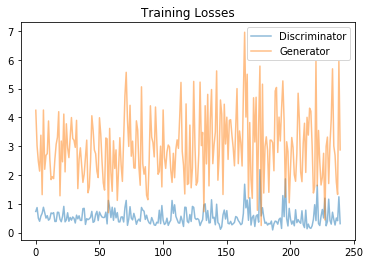

In [37]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [41]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [42]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

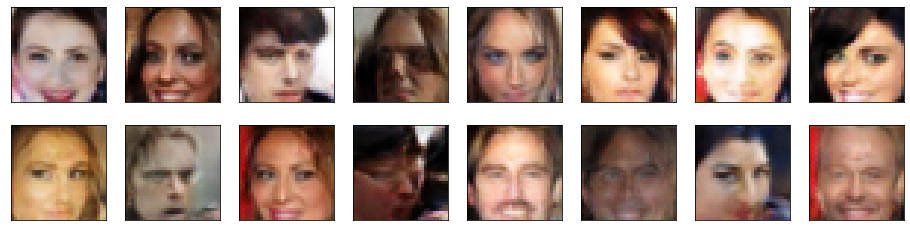

In [43]:
_ = view_samples(-1, samples)

In [311]:
def save_state_dicts(generator: Generator, discriminator: Discriminator) -> None:
    torch.save(G.state_dict(), "generator_state.pt")
    torch.save(D.state_dict(), "discriminator_state.pt")
    

def load_generator() -> Generator:
    generator = Generator(z_size, g_conv_dim).to(device)
    generator.load_state_dict(torch.load("generator_state.pt"))
    return generator


def load_discriminator() -> Discriminator:
    discriminator = Discriminator(d_conv_dim).to(device)
    discriminator.load_state_dict(torch.load("discriminator_state.pt"))
    return discriminator


def show_random_face(generator: Generator) -> None:
    img = generate_fakes(generator)[0]
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = ((img + 1)*255 / (2)).astype(np.uint8)
    ax = plt.axes((0,0,0.2,0.2))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img.reshape((32,32,3)))

In [312]:
save_state_dicts(G, D)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**
- The biggest drawback of the model is the low resolution of generated images. This makes it unfit for serious application. Larger training images and a deeper architecture (likely among other improvements) would be required to generate good quality, higher resolution images.
- Another drawback is the sporadic occurrence of unnatural-looking defects in the faces. For example, sometimes the eyes of the face are impossibly dissimilar or strange structures appear in the forehead area of the face. This problem could probably be attacked by increasing the latent vector size and/or generator depth. This way more features and relationships between them, could be represented and learned. Training for more epochs could also help here.
- If we would like to use the model to generate faces with a broader set of features, such as those characteristic to different ages or ethnic groups, then it should be trained on a data set that contains images with these features. The probability of a particular feature appearing in a generated face will be proportional to that feature's occurrence frequency in the data set.
- Tweaking the hyperparameters such as batch size, learning rate and optimizer beta parameters could improve the training process and the final model performance. However, the initial values chosen based on this paper: https://arxiv.org/pdf/1511.06434.pdf, proved to be adequate. After 16 epochs of training, the generator is able to make images of quality sufficient for this exercise.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.